# 線形回帰　linear regression  
参考にしたやつ  
https://www.amazon.co.jp/Python%E3%81%A7%E5%8B%95%E3%81%8B%E3%81%97%E3%81%A6%E5%AD%A6%E3%81%B6%EF%BC%81-%E3%81%82%E3%81%9F%E3%82%89%E3%81%97%E3%81%84%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%81%AE%E6%95%99%E7%A7%91%E6%9B%B8-%E4%BC%8A%E8%97%A4-%E7%9C%9F/dp/4798144983  
  
https://www.atmarkit.co.jp/ait/articles/2006/04/news013.html

In [11]:
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
%matplotlib notebook

<IPython.core.display.Javascript object>


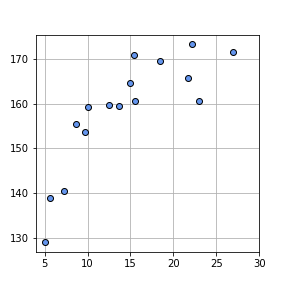

In [12]:
# テストデータ作成　乱数固定
np.random.seed(seed=1)
x_min= 4
x_max = 30
x_n = 16

# 入力変数　年齢 （５～３０歳）
x = 5 + 25 * np.random.rand(x_n)
prm_c = [170, 108, 0.2]

# 目標変数　身長
t = prm_c[0] - prm_c[1] * np.exp(-prm_c[2] * x ) + 4 * np.random.randn(x_n)
np.savez('ch5_data.npz', x=x, x_min=x_min, x_max=x_max, x_n=x_n, t=t)

# テストデータプロット
plt.figure(figsize=(4,4))
plt.plot(x, t, marker='o', linestyle='None', markeredgecolor='black', color='cornflowerblue')
plt.xlim(x_min, x_max)
plt.grid(True)
plt.show()

大体こんな感じの線を引ければ良さそう  
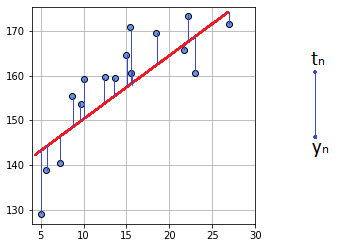
各々の点から直線への距離の合計値が一番小さくなるポイントを探す
つまり、
$$
J = \frac{1}{N} \sum_{n=0}^{N-1} (y_n - t_n)^2　 となる最小の𝐽を探す
$$

平均二乗誤差（MSE） J が最小のときの直線の式はこんな感じになる（回帰式）
$$
y = w_0x + w_1
$$

## なので、Jが最小のときのw0とw1さえわかれば、年齢から身長を予測可能
  
なんで二乗 $ (y_n - t_n)^2 $ するのか？絶対値 $ | y_n - t_n |$ でも良くない？  
⇒結論から言うと絶対値でも良い。絶対値の場合は平均絶対誤差 (MAE)  
https://qiita.com/Hatomugi/items/d00c1a7df07e0e3925a8  


<IPython.core.display.Javascript object>


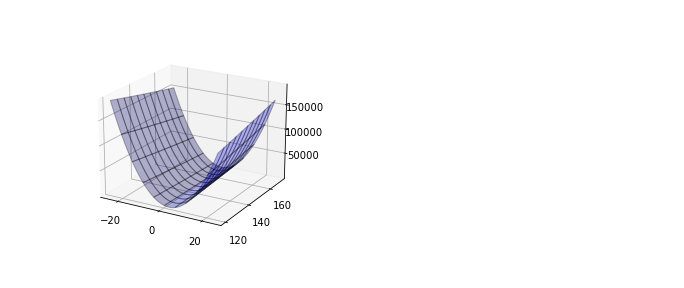

In [13]:
from mpl_toolkits.mplot3d import Axes3D

#平均二乗誤差関数 (MSE: Mean Squared Error) 
def mse_line(x, t, w):
    y = w[0] * x + w[1]
    mse = np.mean((y - t) ** 2)
    return mse

# 100 × 100通りの線を引いてみる
xn = 100
w0_range = [ -25, 25 ] 
w1_range = [ 120, 170 ]
w0 = np.linspace(w0_range[0], w0_range[1], xn)    #等差数列
w1 = np.linspace(w1_range[0], w1_range[1], xn)
j = np.zeros((len(w0), len(w1)))

# 10000通りの平均二乗誤差J, w0, w1を3Dでプロットしてみる
for i0 in range(len(w0)):
    for i1 in range(len(w1)):
        j[i1,i0] = mse_line(x, t, (w0[i0], w1[i1]))
plt.figure(figsize=(9.5, 4))
plt.subplots_adjust(wspace=0.5)
ax= plt.subplot(1,2,1, projection='3d')
ww0, ww1 = np.meshgrid(w0, w1)
ax.plot_surface(ww0, ww1, j, rstride=10, cstride=10, alpha=0.3, color='blue', edgecolor='black')
ax.set_xticks([-20, 0, 20])
ax.set_yticks([120,140,160])
ax.view_init(20, -60)

# jが最小となるのはどこか？ 

## 最小のJを求めたい！！微分で全てが解決する！！！
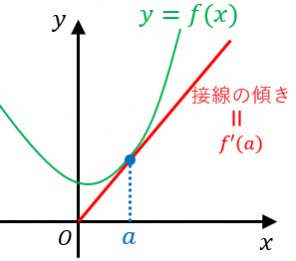


■解析解

$$
J = \frac{1}{N} \sum_{n=0}^{N-1} (y_n - t_n)^2 = \frac{1}{N} \sum_{n=0}^{N-1} (w_0x_n + w_1 - t_n)^2
$$

※ここで偏微分を使う！！！  （∂デル）  
①・・・ w0で偏微分して傾きが0（-> Jが最小）の場合の式はこうなる  
$$
\frac{∂J}{∂w_0} = \frac{2}{N} \sum_{n=0}^{N-1} (w_0x_n + w_1 - t_n)x_n = 0
$$
②・・・ w1で偏微分するとこうなる
$$
\frac{∂J}{∂w_1} = \frac{2}{N} \sum_{n=0}^{N-1} (w_0x_n + w_1 - t_n) = 0
$$
①と②の連立方程式を解けばw0, w1が求められる

In [14]:
# 解析解　連立方程式を解く
def fit_line(x, t):
    mx = np.mean(x)
    mt = np.mean(t)
    mtx = np.mean(t * x)
    mxx = np.mean(x * x)
    w0 = (mtx - mt * mx ) / (mxx - mx**2)
    w1 = mt - w0 * mx
    
    return np.array([w0, w1])

In [15]:
[w0, w1] = fit_line(x, t)
w0, w1

20 * w0 + w1


167.02342729346665

## 連立方程式で解く場合、変数が増えると計算量も増えるので、いずれ計算不可能になる
## 機械学習では連立方程式は使わずに他の手法を使う
### ・基本的な手法、勾配法
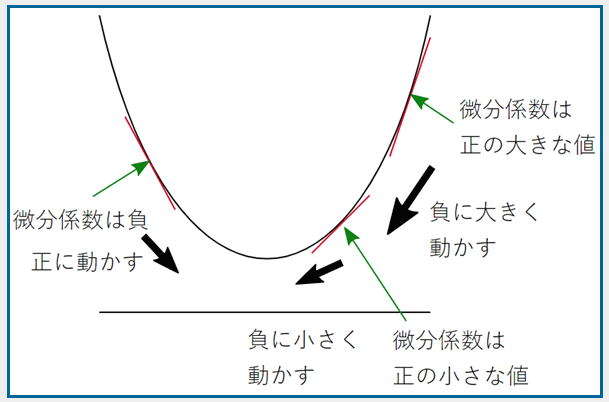

In [17]:
# 平均二乗誤差の勾配
def dmse_line(x, t, w):
    y = w[0] * x + w[1]
    d_w0 = 2 * np.mean((y - t) * x)  # w0で偏微分
    d_w1 = 2 * np.mean(y - t)        # w1で偏微分
    return d_w0, d_w1

# 勾配法 
def fit_line_num(x, t):
    w_init = [10, 165]  # 初期値(適当)
    alpha = 0.001  # 学習率
    tau_max = 100000    # ループ最大数
    eps = 0.1    # ループ停止勾配閾値
    w_hist = np.zeros([tau_max, 2])
    w_hist[0,:] = w_init
    for tau in range(1, tau_max):
        # 平均二乗誤差の勾配（d_w0, d_w1）を求める
        dmse = dmse_line(x, t, w_hist[tau - 1])
        # d_w0, d_w1に「学習率」をかけた値をｗから引いて勾配をずらす。
        #  ⇒正の値ならばｗは少し減少するので0に少し近づく
        #  ⇒負の値ならばｗは少し増加して0に近づく
        # 学習率が大きければ移動量が大きくなるので、少ない計算回数で閾値までくるが、大きすぎると閾値を通り越して発散する可能性がある
        # 学習率が小さければ移動量は少ないので閾値を素通りしなくなるが、計算回数が増える
        # 効率良く学習させるためには学習率を動的に調整してあげる必要がある。
        # 　⇒ 0付近では学習率は小さく、0から離れた場所では学習率は大きくすると効率が良い
        w_hist[tau, 0] = w_hist[tau - 1, 0] - alpha * dmse[0]  
        w_hist[tau, 1] = w_hist[tau - 1, 1] - alpha * dmse[1]
        # 終了判定
        if max(np.absolute(dmse)) < eps:
            # print("np.absolute(dmse) ", np.absolute(dmse))
            break
    w0 = w_hist[tau, 0]
    w1 = w_hist[tau, 1]
    w_hist = w_hist[:tau, :]
    return w0, w1, dmse, w_hist


<IPython.core.display.Javascript object>


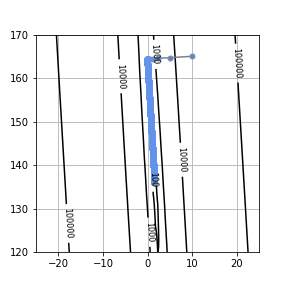

繰り返し回数  13820
W =  1.5399473562672923 136.1761603274906
MSE=  (-0.005793591015883948, 0.09999091251416559)


In [18]:
# MSEの等高線表示
wn = 100
w0_range = [-25, 25]
w1_range = [120, 170]
w0 = np.linspace(w0_range[0], w0_range[1], wn)    #等差数列
w1 = np.linspace(w1_range[0], w1_range[1], wn)
ww0, ww1 = np.meshgrid(w0, w1)
j = np.zeros((len(w0), len(w1)))
for i0 in range(wn):
    for i1 in range(wn):
        j[i1,i0] = mse_line(x, t, (w0[i0], w1[i1]))

plt.figure(figsize=(4,4))
cont = plt.contour(ww0, ww1, j, 30, colors='black', levels=(100,1000,10000,100000))
cont.clabel(fmt='%1.0f', fontsize=8)

plt.grid(True)

W0, W1, dMSE, W_history = fit_line_num(x, t)
print("繰り返し回数 ", W_history.shape[0])
print("W = ", W0, W1)
print("MSE= ", dMSE)
plt.plot(W_history[:,0], W_history[:,1], '.-', color='gray', markersize=10, markeredgecolor='cornflowerblue')
plt.show()

<IPython.core.display.Javascript object>


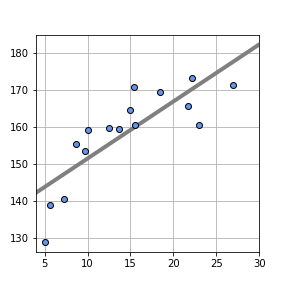

平均二乗誤差 w0=1.540, w1=136.176
標準偏差 SD=7.002 cm


In [19]:
# 線の表示
def show_line(w):
    xb = np.linspace(x_min, x_max, 100)
    y = w[0] * xb + w[1]
    plt.plot(xb, y, color=(.5, .5, .5), linewidth=4)

plt.figure(figsize=(4,4))
w = np.array([W0, W1])
mse = mse_line(x, t, w)
print("平均二乗誤差 w0={0:.3f}, w1={1:.3f}".format(W0, W1))
print("標準偏差 SD={0:.3f} cm".format(np.sqrt(mse)))
show_line(w)
plt.plot(x, t, marker='o', linestyle='None', color='cornflowerblue', markeredgecolor='black')
plt.xlim(x_min, x_max)
plt.grid(True)
plt.show()

In [20]:
# 解析解と勾配法の比較

W = fit_line(x, t)
print("解析解：", W)

W0, W1, dMSE, W_history = fit_line_num(x, t)
print("勾配法： ", [ W0, W1 ])

解析解： [  1.55757515 135.87192426]
勾配法：  [1.5399473562672923, 136.1761603274906]


### ここまでは、入力変数１つ（年齢）で目標変数（身長）を予測してきた（単回帰）
### では、もう一つ入力変数（体重）を増やすとどうなるか？（重回帰）

<IPython.core.display.Javascript object>


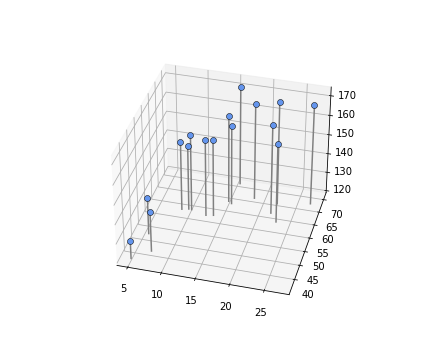

In [21]:
# 重回帰　サンプル作成

# 目標変数　身長   
T = t

# 入力変数0　年齢
X0 = x
X0_min = 5
X0_max = 30

# 入力変数1　体重
np.random.seed(seed = 1)
X1 = 23 * (t / 100)**2 + 2 * np.random.randn(x_n) # BMI平均が23と仮定
X1_min = 40
X1_max = 75

np.savez('data_2.npz', X0=X0, X0_min=X0_min, X0_max=X0_max, X1=X1, X1_min=X1_min, X1_max=X1_max, x_n=x_n, T=T)

def show_data2(ax, x0, x1, t):
    for i in range(len(x0)):
        ax.plot([x0[i], x0[i]], [x1[i], x1[i]], [ 120, t[i]], color='gray')
    
    ax.plot(x0, x1, t, 'o', color='cornflowerblue', markeredgecolor='black', markersize=6, markeredgewidth=0.5)
    # 表示角度 elevはz軸方向から見た仰角，azimはx, y軸方向の方位角を指定
    ax.view_init(elev=35, azim=-75)

plt.figure(figsize=(6, 5))
ax = plt.subplot(1,1,1,projection='3d')
show_data2(ax, X0, X1, T)
plt.show()


<IPython.core.display.Javascript object>


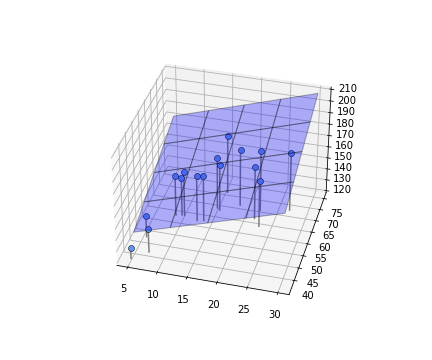

In [22]:
# 面の表示
def show_plane(ax, w):
    px0 = np.linspace(X0_min, X0_max, 5)
    px1 = np.linspace(X1_min, X1_max, 5)
    px0, px1 = np.meshgrid(px0, px1)
    y = w[0]*px0 + w[1]*px1 + w[2]
    ax.plot_surface(px0, px1, y, rstride=1, cstride=1, alpha=0.3, color='blue', edgecolor='black')
    
def mse_plane(x0, x1, t, w):
    y = w[0]*x0 + w[1]*x1 + w[2]
    mse = np.mean((y - t)**2)
    return mse

plt.figure(figsize=(6,5))
ax = plt.subplot(1, 1, 1, projection='3d')

W = [ 1.5, 1, 90]    # 最適なWを求める

show_plane(ax, W)
show_data2(ax, X0, X1, T)
mse = mse_plane(X0, X1, T, W)
plt.show()

単回帰の場合と同じように最小となるJを探せばよい
$$
    J = \frac{1}{N} \sum_{n=0}^{N-1} (W_0X_0 + W_1X_1 + W_2 - t_n)^2　　
$$
回帰式
$$
    y = W_0x_0 + W_1x_1 + W_2
$$

In [23]:
# 解析解　連立方程式を解く

def fit_plane(x0, x1, t):
    c_tx0 = np.mean(t * x0) - np.mean(t) * np.mean(x0)
    c_tx1 = np.mean(t * x1) - np.mean(t) * np.mean(x1)
    c_x0x1 = np.mean(x0 * x1) - np.mean(x0) * np.mean(x1)
    v_x0 = np.var(x0)
    v_x1 = np.var(x1)
    w0 = (c_tx1 * c_x0x1 - v_x1 * c_tx0) / (c_x0x1**2 - v_x0 * v_x1)
    w1 = (c_tx0 * c_x0x1 - v_x0 * c_tx1) / (c_x0x1**2 - v_x0 * v_x1)
    w2 = -w0 * np.mean(x0) - w1 * np.mean(x1) + np.mean(t)
    return np.array([w0, w1, w2])


In [24]:
# 2次元入力時の勾配法 

def dmse_line2(x0, x1, t, w):
    # 𝑦=w0𝑥0 + w1𝑥1 + w2
    y = w[0] * x0 + w[1] * x1 + w[2] 
    
    d_w0 = 2 * np.mean((y - t) * x0)  # w0で偏微分
    d_w1 = 2 * np.mean((y - t) * x1)  # w1で偏微分
    d_w2 = 2 * np.mean(y - t)         # w2で偏微分
    
    return d_w0, d_w1, d_w2

def fit_line_num2(x0, x1, t):
    w_init = [1.5, 1, 90]  # 初期値(適当)
    
    # 学習率  0.001 と 0.00001 にも変えてみて動きを確かめてみよう
    alpha = 0.0001  
    
    tau_max = 100000    # ループ最大数
    eps = 0.1    # ループ停止勾配閾値
    w_hist = np.zeros([tau_max, 3])
    w_hist[0,:] = w_init
    for tau in range(1, tau_max):
        # 勾配を求める
        dmse = dmse_line2(x0, x1, t, w_hist[tau - 1])
        # w0, w1, w2を少しずらす
        w_hist[tau, 0] = w_hist[tau - 1, 0] - alpha * dmse[0]
        w_hist[tau, 1] = w_hist[tau - 1, 1] - alpha * dmse[1]
        w_hist[tau, 2] = w_hist[tau - 1, 2] - alpha * dmse[2]
        #print("##### w_hist[tau]: ", w_hist[tau])
        # 終了判定
        if max(np.absolute(dmse)) < eps:
            #print("np.absolute(dmse) ", np.absolute(dmse))
            break
    w0 = w_hist[tau, 0]
    w1 = w_hist[tau, 1]
    w2 = w_hist[tau, 2]
    w_hist = w_hist[:tau, :]
    return [ w0, w1, w2 ] , dmse, w_hist


In [25]:
# 解析解と勾配法の比較をしてみる

W = fit_plane(X0, X1, T)
print("解析解：", W)

W, dMSE, W_history = fit_line_num2(X0, X1, t)
print("勾配法：", W)

解析解： [ 0.45606532  1.0864049  89.04744652]
勾配法： [0.47260793981787014, 1.0658282776968346, 90.01235305096417]


# さらに入力変数が増えた場合　D次元線形回帰モデル
$$
    y(\boldsymbol{x}) = w_0x_0 + w_1x_1 + … + w_{D-1}x_{D-1} + w_D
$$
  
## y(x)をベクトルで表示（※後で勾配法を使わずにベクトルで解析解を求めるので）  
$$
切片w_Dは含めないで考える。（w_Dは常にx_D = 1を追加して1次元増やすとやりやすい）
$$
$$
    y(\boldsymbol{x}) 
    = \begin{bmatrix} w_0 & … & w_{D-1} \end{bmatrix} \begin{bmatrix} x_0 \\ ︙ \\ x_{D-1} \end{bmatrix} 
    = \boldsymbol{w^Tx}
$$
$$
    \boldsymbol{w} 
    = \begin{bmatrix} w_0 \\ ︙ \\ w_{D-1} \end{bmatrix}  （\boldsymbol{w^T}は\boldsymbol{w}を横にした横ベクトル）
$$

## 平均二乗誤差J
$$
    J = \frac{1}{N} \sum_{n=0}^{N-1} (y(\boldsymbol{x_n}) - t_n)^2 
    = \frac{1}{N} \sum_{n=0}^{N-1} (\boldsymbol{w^Tx_n} - t_n)^2
$$

## 平均二乗誤差Jを偏微分
$$
    各w_iで偏微分するとそれぞれ下記の式になる
$$
$$
    \frac{∂J}{∂w_i} 
    = \frac{2}{N} \sum_{n=0}^{N-1} (\boldsymbol{w^Tx_n} - t_n)x_{n,i}
$$
## 傾きが0でJが最小となる場合（両辺を N/2 倍にして式をシンプルに）
$$
    \sum_{n=0}^{N-1} (\boldsymbol{w^Tx_n} - t_n)x_{n,i} = 0
$$
$ i = [ 0 … D-1 ] $ 　D個の連立方程式になる  
解いていけば解析解が求まるが、例によって連立方程式は使わない

## ベクトルを使って解析解を求める手法
$ x_{n,i} $ を横ベクトル $ \boldsymbol{x_n^T} $ に書き直す
$$
    \sum_{n=0}^{N-1} (\boldsymbol{w^Tx_n} - t_n)x_{n,i} 
    = \sum_{n=0}^{N-1} (\boldsymbol{w^Tx_n} - t_n) \begin{bmatrix} x_{n,0} & … & x_{n,D-1} \end{bmatrix} 
    = \sum_{n=0}^{N-1} (\boldsymbol{w^Tx_n} - t_n)\boldsymbol{x_n^T} 
    = \begin{bmatrix} 0 & … & 0 \end{bmatrix}
$$

式を展開　$ (a - b)c = ac - bc $ の法則は行列でも成り立つ
$$
    \sum_{n=0}^{N-1} (\boldsymbol{w^T x_n x_n^T} - t_n \boldsymbol{x_n^T}) 
    = \boldsymbol{w^T}\sum_{n=0}^{N-1} \boldsymbol{x_n x_n^T} - \sum_{n=0}^{N-1} t_n \boldsymbol{x_n^T} 
    = \begin{bmatrix} 0 & … & 0 \end{bmatrix}
$$

行列を変数に書き換える （スカラ：小文字 $x$　ベクトル：ボルド小文字 $\boldsymbol{x}$　行列：ボルド大文字 $\boldsymbol{X}$） 
$$
    \boldsymbol{X} = \begin{bmatrix}
    x_{0,0} & x_{0,1} & … & x_{0,D-1} \\ 
    x_{1,0} & x_{1,1} & … & x_{1,D-1} \\
    ︙ & ︙ & ︙ & ︙ \\
    x_{N-1,0} & x_{N-1,1} & … & x_{N-1,D-1}
    \end{bmatrix} 　 \boldsymbol{X}はこういう行列だとすると、 \boldsymbol{X^T}は \boldsymbol{X}の転置行列で、
$$
$$
    \sum_{n=0}^{N-1} \boldsymbol{x_nx_n^T} = \boldsymbol{X^T X}　　これがこう書き換えられる
$$
$$
    \sum_{n=0}^{N-1} t_n \boldsymbol{x_n^T} = \boldsymbol{t^T X}　　こっちもこう書き換えられる
$$


### 式を書き換えるとこうなる。ここからどうにか $ \boldsymbol{w} = ... $ の形に持っていければ解が出せる 
$$
    \boldsymbol{w^T X^T X - t^T X} 
    = \begin{bmatrix} 0 & … & 0 \end{bmatrix}
$$
  
両辺を転置
$$
    \boldsymbol{(w^T X^T X - t^T X)^T} 
    = \begin{bmatrix} 0 & … & 0 \end{bmatrix}^T
$$

関係式適用　$ \boldsymbol{(A + B)^T = A^T + B^T} $
$$
    \boldsymbol{(w^T X^T X)^T - (t^T X)^T} 
    = \begin{bmatrix} 0 & … & 0 \end{bmatrix}^T
$$

関係式適用　$ \boldsymbol{(A^T)^T = A} $ 、 $ \boldsymbol{(AB)^T = B^T A^T} $  
$$
    \boldsymbol{(X^T X)^T(w^T)^T - X^T t} 
    = \boldsymbol{(X^T X)w - X^T t}
    = \begin{bmatrix} 0 & … & 0 \end{bmatrix}^T
$$

$ \boldsymbol{X^T t} $ を右辺に移し
$$
    \boldsymbol{(X^T X)w = X^T t}
$$
$  \boldsymbol{(X^T X)} $ を打ち消すために、逆行列 $ \boldsymbol{(X^T X)^{-1}} $ を両辺に左からかけると、解析解！  
※ 逆行列 https://www.geisya.or.jp/~mwm48961/linear_algebra/inverse1.htm
$$
    \boldsymbol{w = (X^T X)^{-1} X^T t}
$$

In [26]:
# D次元線形回帰モデル
# x ・・・ 入力変数 D次元
# t ・・・ 目標変数
def fit_line_D(x, t):
    #print("t:",t.shape)

    # Xの転置行列
    #x_T = np.transpose(x)
    x_T = x.T
    #print("x_T:",x_T)
    
    # x_𝑇とxの内積
    a = x_T.dot(x)
    #print("a:",a)
    
    # 逆行列
    b = np.linalg.inv(a)
    #print("b:",b.shape)

    # ↑とx_Tとの内積
    c = b.dot(x_T)
    #print("c:",b.shape)
    
    # ↑とtとの内積
    w = c.dot(t)
    
    return w
    

In [37]:
# 解析解と勾配法の比較をしてみる

%time W, dMSE, W_history = fit_line_num2(X0, X1, t)
print("勾配法：", W)
print()

%time W = fit_plane(X0, X1, T)
print("解析解 二次方程式：", W)
print()

# ※切片も追加の一次元として考える、追加次元は常に１を取る ⇒ X2 = [ 1, 1, ... ,1 ]
Xn = np.array([X0, X1, np.ones_like(X0)])
Xn = np.transpose(Xn)
%time W = fit_line_D(Xn, T)
print("解析解 ベクトル式：", W)

CPU times: user 158 ms, sys: 0 ns, total: 158 ms
Wall time: 156 ms
勾配法： [0.47260793981787014, 1.0658282776968346, 90.01235305096417]

CPU times: user 476 µs, sys: 0 ns, total: 476 µs
Wall time: 482 µs
解析解 二次方程式： [ 0.45606532  1.0864049  89.04744652]

CPU times: user 143 µs, sys: 0 ns, total: 143 µs
Wall time: 138 µs
解析解 ベクトル式： [ 0.45606532  1.0864049  89.04744652]


In [36]:
x == X0

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [29]:
X0, X1, t

(array([15.42555012, 23.00811234,  5.00285937, 12.55831432,  8.66889727,
         7.30846487,  9.65650528, 13.63901818, 14.91918686, 18.47041835,
        15.47986286, 22.13048751, 10.11130624, 26.95293591,  5.68468983,
        21.76168775]),
 array([70.4323187 , 58.1547777 , 37.21918256, 56.51449493, 57.31720318,
        40.83915269, 57.79206169, 56.93837017, 63.03129677, 65.69415428,
        62.32983909, 64.94508118, 57.72983681, 66.8939307 , 46.67837662,
        61.08315123]),
 array([170.91013145, 160.67559882, 129.00206616, 159.70139552,
        155.46058905, 140.56134369, 153.65466385, 159.42939554,
        164.70423898, 169.64527574, 160.71257522, 173.28709855,
        159.31193249, 171.51757345, 138.9570433 , 165.8744074 ]))

In [293]:
# ライブラリを使った結果と比較
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

Xv = np.transpose(np.array([X0, X1]))    # fitの第一引数、入力変数、n次元縦ベクトル(追加次元は不要)
Tv = T.reshape(-1, 1)                    # fitの第二引数、目標変数、これも縦ベクトル、今回は1次元なので縦arrayに変換

# 学習する
%time lr.fit(Xv, Tv)
print("学習した係数:[w0, w1] = ", lr.coef_, "  切片:[w2] = ", lr.intercept_)

CPU times: user 1.23 ms, sys: 25 µs, total: 1.25 ms
Wall time: 858 µs
学習した係数:[w0, w1] =  [[0.45606532 1.0864049 ]]   切片:[w2] =  [89.04744652]


$$
    \boldsymbol{w = (X^T X)^{-1} X^T t}
$$

In [307]:
def fit_line_np(X, t):
    b = np.linalg.inv(X.T.dot(X))
    c = b.dot(X.T)
    w = c.dot(t)
    return w

In [319]:
def fit_line_np2(X, t):
    a = np.linalg.inv(X)
    w = a.dot(t)
    return w

In [311]:
fit_line_np(Xn,T)

array([ 0.45606532,  1.0864049 , 89.04744652])

In [320]:
fit_line_np2(Xn,T)

LinAlgError: Last 2 dimensions of the array must be square